## Multisequence Alignment (MSA)

Proteins are made up of sequences of amino acids chained together. Their amino acid sequence determines their structure and function. Finding proteins with similar sequences, or homologous proteins, is very useful in identifying the structures and functions of newly discovered proteins as well as identifying their ancestry. Below is an example of what a protein amino acid multisequence alignment may look like, taken from [2].

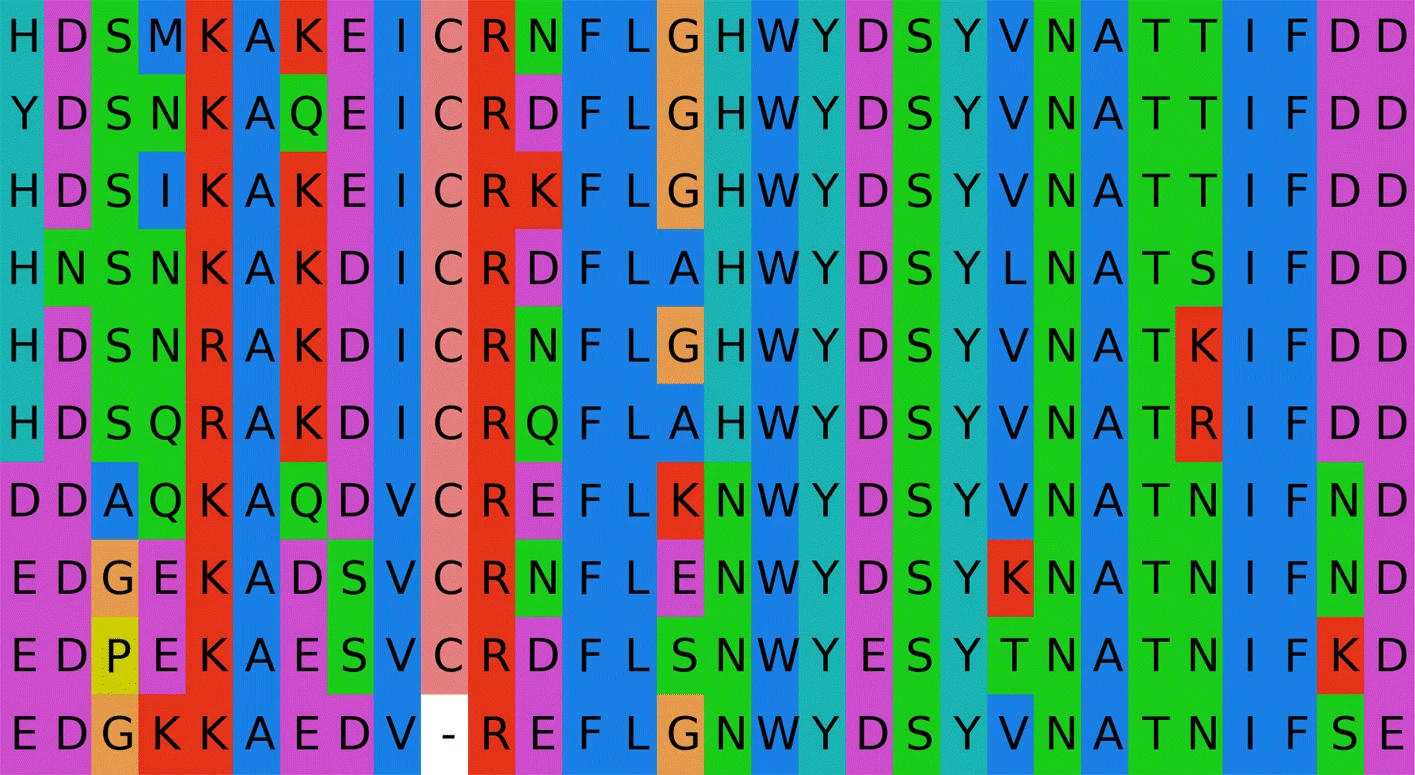

To understand Multiple Sequence Alignment (MSA), it's helpful to first grasp pairwise sequence alignment. Pairwise sequence alignment is a hypothesis about how two sequences may have evolved from a common ancestor through events such as mutation, insertion, and deletion. When a nucleotide is aligned with a gap, it represents an indel event—either a deletion in one sequence or an insertion in the other. When two different nucleotides are aligned, this is typically interpreted as a substitution or mutation event introduced in one or both of the lineages since the time they diverged from one another.If identical nucleotides are aligned, it suggests a conserved region, which may indicate functional importance and possibly homology—evidence that the sequences share a common ancestor. Pairwise alignment also provides an optimal alignment of two sequences by strategically introducing gaps, making it useful for comparing sequences and identifying conserved regions.The alignment is an optimal hypothesis but may not reflect the actual evolutionary path.

Using profile-sequence comparison instead of just sequence-sequence comparison when constructing multiple sequence alignment utilizes more information. Sequence profiles are based on frequencies of each of the 20 amino acids at each position in a sequence. Sequence profiles (or PSSMs) tell us how likely it is that a particular amino acid (or nucleotide in DNA/RNA sequences) at a specific position is due to conservation rather than random chance.This is achieved through the use of log-odds scores that compare the observed frequency of an amino acid at a particular position in the multiple sequence alignment (MSA) to its expected frequency under random conditions (i.e., the background probability).

Here is how the position frequence matrix looks. Sequence profile is constructed through the log odds score of these frequencies.
<img src="https://web.stanford.edu/class/sbio228/public/lectures/lec9/Lecture9/Fold_Recognition/images/Use_a_Sequence_Profile.jpg">

A Profile Hidden Markov Model is a probabilistic model that represents the sequence conservation at each position (including insertions and deletions) and the likelihood of transitioning between different sequence states.

## Colab

This tutorial and the rest in this sequence can be done in Google colab. If you'd like to open this notebook in colab, you can use the following link.

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/deepchem/deepchem/blob/master/examples/tutorials/Multisequence_Alignments.ipynb)

## HH-suite
This tutorial will show you the basics of how to use hh-suite. [hh-suite](https://github.com/soedinglab/hh-suite) is an open source package for searching protein sequence alignments for homologous proteins. It is the current state of the art for building highly accurate multisequence alignments (MSA) from a single sequence or from MSAs.

HH-suite leverages profile HMMs to improve the accuracy of detecting remote homologs (sequences that share a common ancestor but are highly diverged).

Instead of comparing a single sequence against a database of sequences, it aligns one profile HMM against another profile HMM.The idea is that by comparing two profile HMMs, it can detect relationships between sequence families that are not apparent when comparing just sequences. This is particularly useful when dealing with highly diverged proteins or detecting remote homologs.

## Setup

Let's start by importing the deepchem sequence_utils module and downloading a database to compare our query sequence to.

hh-suite provides a set of HMM databases that will work with the software, which you can find here: http://wwwuser.gwdg.de/~compbiol/data/hhsuite/databases/hhsuite_dbs

dbCAN is a good one for this tutorial because it is a relatively smaller download. 

In [34]:
from deepchem.utils import sequence_utils

In [36]:
%%bash
mkdir hh
cd hh 
mkdir databases; cd databases
wget http://wwwuser.gwdg.de/~compbiol/data/hhsuite/databases/hhsuite_dbs/dbCAN-fam-V9.tar.gz
tar xzvf dbCAN-fam-V9.tar.gz

dbCAN-fam-V9_a3m.ffdata
dbCAN-fam-V9_a3m.ffindex
dbCAN-fam-V9_hhm.ffdata
dbCAN-fam-V9_hhm.ffindex
dbCAN-fam-V9_cs219.ffdata
dbCAN-fam-V9_cs219.ffindex
dbCAN-fam-V9.md5sum


--2022-02-11 12:47:57--  http://wwwuser.gwdg.de/~compbiol/data/hhsuite/databases/hhsuite_dbs/dbCAN-fam-V9.tar.gz
Resolving wwwuser.gwdg.de (wwwuser.gwdg.de)... 134.76.10.111
Connecting to wwwuser.gwdg.de (wwwuser.gwdg.de)|134.76.10.111|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 25882327 (25M) [application/x-gzip]
Saving to: ‘dbCAN-fam-V9.tar.gz’

     0K .......... .......... .......... .......... ..........  0%  195K 2m10s
    50K .......... .......... .......... .......... ..........  0%  391K 97s
   100K .......... .......... .......... .......... ..........  0% 55.2M 65s
   150K .......... .......... .......... .......... ..........  0%  392K 64s
   200K .......... .......... .......... .......... ..........  0%  127M 51s
   250K .......... .......... .......... .......... ..........  1% 50.8M 43s
   300K .......... .......... .......... .......... ..........  1% 85.5M 37s
   350K .......... .......... .......... .......... ..........  1%  395K 40s
   

## Using hhsearch
hhblits and hhsearch are the main functions in hhsuite which identify homologous proteins. They do this by calculating a profile hidden Markov model (HMM) from a given alignment and searching over a reference HMM proteome database using the Viterbi algorithm. Then the most similar HMMs are realigned and output to the user. To learn more, check out the original paper in the references above.

Run a function from hhsuite with no parameters to read its documentation.

In [37]:
!hhsearch

HHsearch 3.3.0
Search a database of HMMs with a query alignment or query HMM
(c) The HH-suite development team
Steinegger M, Meier M, Mirdita M, Vöhringer H, Haunsberger S J, and Söding J (2019)
HH-suite3 for fast remote homology detection and deep protein annotation.
BMC Bioinformatics, doi:10.1186/s12859-019-3019-7

Usage: hhsearch -i query -d database [options]                       
 -i <file>      input/query multiple sequence alignment (a2m, a3m, FASTA) or HMM
Options:                                                                        
 -d <name>      database name (e.g. uniprot20_29Feb2012)                        
                Multiple databases may be specified with '-d <db1> -d <db2> ...'
 -e     [0,1]   E-value cutoff for inclusion in result alignment (def=0.001)       

Input alignment format:                                                       
 -M a2m         use A2M/A3M (default): upper case = Match; lower case = Insert;
               '-' = Delete; '.' = gaps al

Let's do an example. Say we have a protein which we want to compare to a MSA in order to identify any homologous regions. For this we can use hhsearch. 

Now let's take some protein sequence and search through the dbCAN database to see if we can find any potential homologous regions. First we will specify the sequence and save it as a FASTA file or a3m file in order to be readable by hhsearch. I pulled this sequence from the example query.a3m in the hhsuite data directory.

In [38]:
with open('protein.fasta', 'w') as f:
    f.write("""
>Uncharacterized bovine protein (Fragment)
--PAGGQCtgiWHLLTRPLRP--QGRLPGLRVKYVFLVWLGVFAGSWMAYTHYSSYAELCRGHICQVVICDQFRKGIISGSICQDLCHLHQVEWRTCLSSVPGQQVYSGLWQGKEVTIKCGIEESLNSKAGSDGAPRRELVLFDKPSRGTSIKEFREMTLSFLKANLGDLPSLPALVGRVLLMADFNKDNRVSLAEAKSVWALLQRNEFLLLLSLQEKEHASRLLGYCGDLYVTEGVPLSSWPGATLPPLLRPLLPPALHGALQQWLGPAWPWRAKIAMGLLEFVEDLFHGAYGNFYMCETTLANVGYTAKYDFRMADLQQVAPEAAVRRFLRGRRCEHSADCTYGRDCRAPCDTLMRQCKGDLVQPNLAKVCELLRDYLLPGAPAALRPELGKQLRTCTTLSGLASQVEAHHSLVLSHLKSLLWKEISDSRYT
""")

Then we can call hhsearch, specifying the query sequence with the -i flag, the database to search through with -d, and the output with -o.

In [39]:
from deepchem.utils import sequence_utils
dataset_path = 'protein.fasta'
data_dir = 'hh/databases'
results = sequence_utils.hhsearch(dataset_path,database='dbCAN-fam-V9', data_dir=data_dir)


- 12:48:13.301 INFO: Search results will be written to /home/tony/github/deepchem/examples/tutorials/protein.hhr

- 12:48:13.331 INFO: /home/tony/github/deepchem/examples/tutorials/protein.fasta is in A2M, A3M or FASTA format

- 12:48:13.331 WARNING: Input alignment /home/tony/github/deepchem/examples/tutorials/protein.fasta looks like aligned FASTA instead of A2M/A3M format. Consider using '-M first' or '-M 50'

- 12:48:13.331 INFO: NOTE: Use the '-add_cons' option to calculate a consensus sequence as first sequence of the alignment with hhconsensus or hhmake.

- 12:48:13.331 INFO: Searching 683 database HHMs without prefiltering

- 12:48:13.332 INFO: Iteration 1

- 12:48:13.420 INFO: Scoring 683 HMMs using HMM-HMM Viterbi alignment

- 12:48:13.460 INFO: Alternative alignment: 0

- 12:48:13.611 INFO: 683 alignments done

- 12:48:13.612 INFO: Alternative alignment: 1

- 12:48:13.625 INFO: 38 alignments done

- 12:48:13.625 INFO: Alternative alignment: 2

- 12:48:13.629 INFO: 3 alignmen

In [40]:

#open the results and print them
f = open("protein.hhr", "r")
print(f.read())

Query         Uncharacterized bovine protein (Fragment)
Match_columns 431
No_of_seqs    1 out of 1
Neff          1
Searched_HMMs 683
Date          Fri Feb 11 12:48:13 2022
Command       hhsearch -i /home/tony/github/deepchem/examples/tutorials/protein.fasta -d hh/databases/dbCAN-fam-V9 -oa3m /home/tony/github/deepchem/examples/tutorials/results.a3m -cpu 4 -e 0.001 

 No Hit                             Prob E-value P-value  Score    SS Cols Query HMM  Template HMM
  1 ABJ15796.1|231-344|9.6e-33       8.2     2.9  0.0042   25.2   0.0   13  224-236    40-52  (116)
  2 lcl|consensus                    5.1     5.2  0.0076   17.1   0.0   14  182-195     1-14  (21)
  3 ABW08129.1|GT4|GT97||563-891     4.8     5.7  0.0084   26.6   0.0   46  104-150    93-140 (329)
  4 AEO62162.1|AA13||19-250          4.6       6  0.0087   25.5   0.0   18  330-347   139-156 (232)
  5 BAF49076.1|GH5_26.hmm|8.3e-11|   2.4      13    0.02   21.9   0.0   12  287-298    45-56  (141)
  6 BBD44721.1 Hypothetical prote

Two files are output and saved to the dataset directory, results.hhr and results.a3m. results.hhr is the hhsuite results file, which is a summary of the results. results.a3m is the actual MSA file.

In the hhr file, the 'Prob' column describes the estimated probability of the query sequence being at least partially homologous to the template. Probabilities of 95% or more are nearly certain, and probabilities of 30% or more call for closer consideration. The E value tells you how many random matches with a better score would be expected if the searched database was unrelated to the query sequence. These results show that none of the sequences align well with our randomly chosen protein, which is to be expected because our query sequence was chosen at random.

Now let's check the results if we use a sequence that we know will align with something in the dbCAN database. I pulled this protein from the dockerin.faa file in dbCAN.

In [41]:
with open('protein2.fasta', 'w') as f:
    f.write(""">dockerin,22,NCBI-Bacteria,gi|125972715|ref|YP_001036625.1|,162-245,0.033
SCADLNGDGKITSSDYNLLKRYILHLIDKFPIGNDETDEGINDGFNDETDEDINDSFIEANSKFAFDIFKQISKDEQGKNVFIS
""")
    
dataset_path = 'protein2.fasta'
sequence_utils.hhsearch(dataset_path,database='dbCAN-fam-V9', data_dir=data_dir)

#open the results and print them
f = open("protein2.hhr", "r")
print(f.read())

- 12:48:13.823 INFO: Search results will be written to /home/tony/github/deepchem/examples/tutorials/protein2.hhr

- 12:48:13.851 INFO: /home/tony/github/deepchem/examples/tutorials/protein2.fasta is in A2M, A3M or FASTA format

- 12:48:13.852 INFO: Searching 683 database HHMs without prefiltering

- 12:48:13.852 INFO: Iteration 1

- 12:48:13.873 INFO: Scoring 683 HMMs using HMM-HMM Viterbi alignment

- 12:48:13.913 INFO: Alternative alignment: 0

- 12:48:13.979 INFO: 683 alignments done

- 12:48:13.979 INFO: Alternative alignment: 1

- 12:48:13.982 INFO: 10 alignments done

- 12:48:13.982 INFO: Alternative alignment: 2

- 12:48:13.984 INFO: 3 alignments done

- 12:48:13.984 INFO: Alternative alignment: 3

- 12:48:13.986 INFO: 3 alignments done



Query         dockerin,22,NCBI-Bacteria,gi|125972715|ref|YP_001036625.1|,162-245,0.033
Match_columns 84
No_of_seqs    1 out of 1
Neff          1
Searched_HMMs 683
Date          Fri Feb 11 12:48:14 2022
Command       hhsearch -i /home/tony/github/deepchem/examples/tutorials/protein2.fasta -d hh/databases/dbCAN-fam-V9 -oa3m /home/tony/github/deepchem/examples/tutorials/results.a3m -cpu 4 -e 0.001 

 No Hit                             Prob E-value P-value  Score    SS Cols Query HMM  Template HMM
  1 lcl|consensus                   97.0 5.9E-08 8.7E-11   43.5   0.0   21    4-24      1-21  (21)
  2 ABN51673.1|GH124|2-334|2.6e-21  92.5 0.00033 4.8E-07   45.5   0.0   68    1-75     21-88  (318)
  3 AAK20911.1|PL11|47-657|0        15.7     1.1  0.0017   27.6   0.0   14    1-14    329-342 (606)
  4 AGE62576.1|PL11_1.hmm|0|1-596   10.2     2.1  0.0031   26.0   0.0   13    1-13    118-130 (602)
  5 AAZ21803.1|GH103|26-328|1.7e-8   9.3     2.4  0.0035   22.4   0.0   10    4-13    175-184 (293)
  

- 12:48:14.063 INFO: Premerge done

- 12:48:14.063 INFO: Realigning 10 HMM-HMM alignments using Maximum Accuracy algorithm

- 12:48:14.084 INFO: 4 sequences belonging to 4 database HMMs found with an E-value < 0.001

- 12:48:14.084 INFO: Number of effective sequences of resulting query HMM: Neff = 1.39047



As you can see, there are 2 sequences which are a match for our query sequence. 

## Using hhblits
hhblits works in much the same way as hhsearch, but it is much faster and slightly less sensitive. This would be more suited to searching very large databases, or producing a MSA with multiple sequences instead of just one. Let's make use of that by using our query sequence to create an MSA. We could then use that MSA, with its family of proteins, to search a larger database for potential matches. This will be much more effective than searching a large database with a single sequence.

We will use the same dbCAN database. I will pull a glycoside hydrolase protein from UnipProt, so it will likely be related to some proteins in dbCAN, which has carbohydrate-active enzymes.

The option -oa3m will tell hhblits to output an MSA as an a3m file. The -n option specifies the number of iterations. This is recommended to keep between 1 and 4, we will try 2.

In [42]:

!wget -O protein3.fasta https://www.uniprot.org/uniprot/G8M3C3.fasta

dataset_path = 'protein3.fasta'
sequence_utils.hhblits(dataset_path,database='dbCAN-fam-V9', data_dir=data_dir)

#open the results and print them
f = open("protein3.hhr", "r")
print(f.read())

--2022-02-11 12:48:14--  https://www.uniprot.org/uniprot/G8M3C3.fasta
Resolving www.uniprot.org (www.uniprot.org)... 193.62.193.81
Connecting to www.uniprot.org (www.uniprot.org)|193.62.193.81|:443... connected.
HTTP request sent, awaiting response... 200 
Length: 897 [text/plain]
Saving to: ‘protein3.fasta’

protein3.fasta      100%[===================>]     897  --.-KB/s    in 0s      

2022-02-11 12:48:15 (1.70 GB/s) - ‘protein3.fasta’ saved [897/897]



- 12:48:15.242 WARNING: Ignoring unknown option -n

- 12:48:15.242 WARNING: Ignoring unknown option 2

- 12:48:15.242 INFO: Search results will be written to /home/tony/github/deepchem/examples/tutorials/protein3.hhr

- 12:48:15.270 INFO: /home/tony/github/deepchem/examples/tutorials/protein3.fasta is in A2M, A3M or FASTA format

- 12:48:15.271 INFO: Searching 683 database HHMs without prefiltering

- 12:48:15.271 INFO: Iteration 1

- 12:48:15.424 INFO: Scoring 683 HMMs using HMM-HMM Viterbi alignment

- 12:48:15.465 INFO: Alternative alignment: 0

- 12:48:15.658 INFO: 683 alignments done

- 12:48:15.659 INFO: Alternative alignment: 1

- 12:48:15.697 INFO: 92 alignments done

- 12:48:15.697 INFO: Alternative alignment: 2

- 12:48:15.710 INFO: 7 alignments done

- 12:48:15.710 INFO: Alternative alignment: 3



Query         tr|G8M3C3|G8M3C3_HUNCD Dockerin-like protein OS=Hungateiclostridium clariflavum (strain DSM 19732 / NBRC 101661 / EBR45) OX=720554 GN=Clocl_4007 PE=4 SV=1
Match_columns 728
No_of_seqs    1 out of 1
Neff          1
Searched_HMMs 683
Date          Fri Feb 11 12:48:16 2022
Command       hhsearch -i /home/tony/github/deepchem/examples/tutorials/protein3.fasta -d hh/databases/dbCAN-fam-V9 -oa3m /home/tony/github/deepchem/examples/tutorials/results.a3m -cpu 4 -n 2 -e 0.001 

 No Hit                             Prob E-value P-value  Score    SS Cols Query HMM  Template HMM
  1 AAA91086.1|GH48|150-238|4.7e-1 100.0  7E-195  1E-197 1475.1   0.0  608   31-644     1-619 (620)
  2 lcl|consensus                   91.8 0.00051 7.4E-07   37.5   0.0   20  668-687     1-20  (21)
  3 ABN51673.1|GH124|2-334|2.6e-21  52.5   0.096 0.00014   40.1   0.0   66  663-728    19-85  (318)
  4 CAR68154.1|GH88|62-388|4.9e-13  10.5       2   0.003   30.7   0.0   43  421-463   181-223 (329)
  5 ACY49347.1

- 12:48:16.066 INFO: Premerge done

- 12:48:16.066 INFO: Realigning 10 HMM-HMM alignments using Maximum Accuracy algorithm

- 12:48:16.115 INFO: 4 sequences belonging to 4 database HMMs found with an E-value < 0.001

- 12:48:16.115 INFO: Number of effective sequences of resulting query HMM: Neff = 2.41642



We can see that the exact protein was found in dbCAN in hit 1, but also some highly related proteins were found in hits 1-5. This query.a3m MSA can then be useful if we want to search a larger database like UniProt or Uniclust because it includes this more diverse selection of related protein sequences. 

## Other hh-suite functions
hhsuite contains other functions which may be useful if you are working with MSA or HMMs. For more detailed information, see the documentation at https://github.com/soedinglab/hh-suite/wiki

hhmake: Build an HMM from an input MSA

hhfilter: Filter an MSA by max sequence identity, coverage, and other criteria

hhalign: Calculate pairwise alignments etc. for two HMMs/MSAs

hhconsensus: Calculate the consensus sequence for an A3M/FASTA input file

reformat.pl: Reformat one or many MSAs

addss.pl: Add PSIPRED predicted secondary structure to an MSA or HHM file

hhmakemodel.pl: Generate MSAs or coarse 3D models from HHsearch or HHblits 
results

hhmakemodel.py: Generates coarse 3D models from HHsearch or HHblits results and modifies cif files such that they are compatible with MODELLER

hhsuitedb.py: Build HHsuite database with prefiltering, packed MSA/HMM, and index files

splitfasta.pl: Split a multiple-sequence FASTA file into multiple single-sequence files

renumberpdb.pl: Generate PDB file with indices renumbered to match input sequence indices

HHPaths.pm: Configuration file with paths to the PDB, BLAST, PSIPRED etc.
mergeali.pl: Merge MSAs in A3M format according to an MSA of their seed sequences

pdb2fasta.pl: Generate FASTA sequence file from SEQRES records of globbed pdb files

cif2fasta.py: Generate a FASTA sequence from the pdbx_seq_one_letter_code entry of the entity_poly of globbed cif files

pdbfilter.pl: Generate representative set of PDB/SCOP sequences from pdb2fasta.pl output

pdbfilter.py: Generate representative set of PDB/SCOP sequences from cif2fasta.py output

References:

[1] Steinegger M, Meier M, Mirdita M, Vöhringer H, Haunsberger S J, and Söding J (2019) HH-suite3 for fast remote homology detection and deep protein annotation, BMC Bioinformatics, 473. doi: 10.1186/s12859-019-3019-7

[2] Kunzmann, P., Mayer, B.E. & Hamacher, K. Substitution matrix based color schemes for sequence alignment visualization. BMC Bioinformatics 21, 209 (2020). https://doi.org/10.1186/s12859-020-3526-6

[3]Identifying DNA and protein patterns with statistically significant alignments of multiple 
sequences. https://www.researchgate.net/publication/12812078_

[4]https://github.com/soedinglab/hh-suite/wiki#what-are-hmm-hmm-comparisons-and-why-are-they-so-powerful

# Congratulations! Time to join the Community!

Congratulations on completing this tutorial notebook! If you enjoyed working through the tutorial, and want to continue working with DeepChem, we encourage you to finish the rest of the tutorials in this series. You can also help the DeepChem community in the following ways:

## Star DeepChem on [GitHub](https://github.com/deepchem/deepchem)
This helps build awareness of the DeepChem project and the tools for open source drug discovery that we're trying to build.

## Join the DeepChem Gitter
The DeepChem [Gitter](https://gitter.im/deepchem/Lobby) hosts a number of scientists, developers, and enthusiasts interested in deep learning for the life sciences. Join the conversation!